<a href="https://colab.research.google.com/github/yeesem/Soft-Computing/blob/main/Soft_Computing_Assignment_Fuzzy_Logic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install -U ucimlrepo
!pip install scikit-fuzzy

In [ ]:
import pandas as pd
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
communities_and_crime = fetch_ucirepo(id=183)

# data (as pandas dataframes)
X = communities_and_crime.data.features
y = communities_and_crime.data.targets

# **Data Exploration**

In [ ]:
print("Number of columns : ", X.shape[1])
print("Number of rows    : ", X.shape[0])

Number of columns :  127
Number of rows    :  1994


In [ ]:
X.head()

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,PolicAveOTWorked,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop
0,8,?,?,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.29,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14
1,53,?,?,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,?,0.02,0.12,0.45,?,?,?,?,0.00,?
2,24,?,?,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,?,0.01,0.21,0.02,?,?,?,?,0.00,?
3,34,5,81440,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,?,0.02,0.39,0.28,?,?,?,?,0.00,?
4,42,95,6096,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,?,0.04,0.09,0.02,?,?,?,?,0.00,?


In [ ]:
for index,col in enumerate(X.columns):
  print("Column : ",index)
  print(col , " : ", X[col].info())
  print("Missing value : ",np.sum(X[col] == '?'))
  print(X[col].unique())
  print("\n\n")

Column :  0
<class 'pandas.core.series.Series'>
RangeIndex: 1994 entries, 0 to 1993
Series name: state
Non-Null Count  Dtype
--------------  -----
1994 non-null   int64
dtypes: int64(1)
memory usage: 15.7 KB
state  :  None
Missing value :  0
[ 8 53 24 34 42  6 44 21 29 36 25 55 19 18 12 41 39 54  9  1 51 40 35 33
 48  4 37 49 46 28 22 45 16 47  5 50 13 23 38 27 20 56  2 11 32 10]



Column :  1
<class 'pandas.core.series.Series'>
RangeIndex: 1994 entries, 0 to 1993
Series name: county
Non-Null Count  Dtype 
--------------  ----- 
1994 non-null   object
dtypes: object(1)
memory usage: 15.7+ KB
county  :  None
Missing value :  1174
['?' '5' '95' '7' '21' '87' '187' '1' '27' '129' '31' '193' '29' '680'
 '23' '3' '19' '35' '790' '53' '9' '119' '99' '17' '11' '135' '133' '45'
 '39' '61' '43' '157' '15' '13' '37' '107' '89' '41' '93' '71' '590' '55'
 '101' '75' '57' '63' '760' '69' '25' '830' '77' '155' '151' '123' '113'
 '49' '139' '169' '630' '79' '510' '65' '81' '105' '141' '33' '59' '131

In [ ]:
index_of_col_with_missing_value = []

for index,col in enumerate(X.columns):
  if X[col].astype(str).str.contains("\?").any():
    print("Column name  : ",col)
    print("Column type  : ",type(X[col]))
    print("Column index : ",index)
    print("Number of missing value : ", np.sum(X[col] == "?"))
    index_of_col_with_missing_value.append(index)
    print("\n")

print("Total number of col with missing value : ", len(index_of_col_with_missing_value))
print(index_of_col_with_missing_value)

Column name  :  county
Column type  :  <class 'pandas.core.series.Series'>
Column index :  1
Number of missing value :  1174


Column name  :  community
Column type  :  <class 'pandas.core.series.Series'>
Column index :  2
Number of missing value :  1177


Column name  :  OtherPerCap
Column type  :  <class 'pandas.core.series.Series'>
Column index :  30
Number of missing value :  1


Column name  :  LemasSwornFT
Column type  :  <class 'pandas.core.series.Series'>
Column index :  101
Number of missing value :  1675


Column name  :  LemasSwFTPerPop
Column type  :  <class 'pandas.core.series.Series'>
Column index :  102
Number of missing value :  1675


Column name  :  LemasSwFTFieldOps
Column type  :  <class 'pandas.core.series.Series'>
Column index :  103
Number of missing value :  1675


Column name  :  LemasSwFTFieldPerPop
Column type  :  <class 'pandas.core.series.Series'>
Column index :  104
Number of missing value :  1675


Column name  :  LemasTotalReq
Column type  :  <class 'pan

In [ ]:
#Convert data into dataframe
feature = pd.DataFrame(X,columns = communities_and_crime.data.features_name)
target = pd.DataFrame(y,columns = communities_and_crime.data.targets_name)

# **Data Cleaning and Preprocessing**

In [ ]:
#Drop col with missing value
col_to_drop = []
col_to_remain = []

for index in index_of_col_with_missing_value:
  col = feature.columns[index]
  if np.sum(feature[col]=="?") > 1000:
    col_to_drop.append(col)
  else:
    col_to_remain.append(col)

print("Column's names to drop   : ", col_to_drop)
print("Column's names to remain : ", col_to_remain)

#Drop the columns
feature.drop(columns = col_to_drop ,axis = 1,inplace = True)

#Replace the "?" value with median value
feature[col_to_remain] = feature[col_to_remain].replace("?",np.nan).astype(float)
feature.loc[:, col_to_remain] = feature[col_to_remain].fillna(feature[col_to_remain].median())

check_null = feature.isnull().sum() > 0
columns_with_null = check_null[check_null].index.tolist()
print("Columns with missing value : ",columns_with_null)

Column's names to drop   :  ['county', 'community', 'LemasSwornFT', 'LemasSwFTPerPop', 'LemasSwFTFieldOps', 'LemasSwFTFieldPerPop', 'LemasTotalReq', 'LemasTotReqPerPop', 'PolicReqPerOffic', 'PolicPerPop', 'RacialMatchCommPol', 'PctPolicWhite', 'PctPolicBlack', 'PctPolicHisp', 'PctPolicAsian', 'PctPolicMinor', 'OfficAssgnDrugUnits', 'NumKindsDrugsSeiz', 'PolicAveOTWorked', 'PolicCars', 'PolicOperBudg', 'LemasPctPolicOnPatr', 'LemasGangUnitDeploy', 'PolicBudgPerPop']
Column's names to remain :  ['OtherPerCap']
Columns with missing value :  []


In [ ]:
feature = feature.apply(pd.to_numeric,errors='ignore')


#Check Column with 'Object' Data Type
col_with_obj_datatype = []
for index,col in enumerate(feature.columns):
  if str(feature[col].dtype) != 'float64' and  str(feature[col].dtype) != 'int':
    print("Column name  : ",col)
    print("Column index : ",index)
    col_with_obj_datatype.append(col)
    print("\n")

feature.drop(columns = col_with_obj_datatype,inplace = True)

Column name  :  state
Column index :  0


Column name  :  communityname
Column index :  1


Column name  :  fold
Column index :  2




In [ ]:
#Split the data into train,test and validaton set
from sklearn.model_selection import train_test_split

test_size = 0.3

X_train,X_temp,y_train,y_temp = train_test_split(feature,target,test_size = test_size,random_state = 42)
X_test,X_val,y_test,y_val = train_test_split(X_temp,y_temp,test_size = 0.5,random_state = 42)

print("Training data shape:", X_train.shape, y_train.shape)
print("Testing data shape:", X_test.shape, y_test.shape)
print("Validation data shape:", X_val.shape, y_val.shape)

Training data shape: (1395, 100) (1395, 1)
Testing data shape: (299, 100) (299, 1)
Validation data shape: (300, 100) (300, 1)


# **Feature Selection - GA Algorithm**

In [ ]:
import random
import statistics
from sklearn.model_selection import cross_val_score
import xgboost as xgb

def genetic_algo(data,features,target,population_size,tol_level,top_number):


  def init_population(population_size,c,top_number):
    population = []
    for i in range(population_size):
      individual = [0]*c
      j = 0
      while(j<top_number):
        p = random.uniform(0,1)
        position = random.randrange(c)
        if(p>=0.5 and individual[position]==0):
          individual[position]=1
          j=j+1

      #edge case if all genes are 0 then we will make any one gene as 1
      if(sum(individual)==0):
        position = random.randrange(c)
        individual[position] = 1

      population.append(individual)
    # print('population is ')
    # print(population)
    # print('------------------')
    return population




  def calculate_fitness(features,target):
    model = xgb.XGBRegressor()
    scores = cross_val_score(model, features, target, cv=5, scoring='neg_mean_squared_error')
    return scores.mean()



  def get_fitness(population,data):
    fitness_values = []
    for individual in population:
      df = data
      i=0
      for column in data:
        if(individual[i]==0):
          df = df.drop(column,axis=1)
        i=i+1

      features = df
      individual_fitness = calculate_fitness(features,target)
      fitness_values.append(individual_fitness)

    return fitness_values



  def select_parents(population,fitness_values):
    parents = []
    total = sum(fitness_values)
    norm_fitness_values = [x/total for x in fitness_values]

    #find cumulative fitness values for roulette wheel selection
    cumulative_fitness = []
    start = 0
    for norm_value in norm_fitness_values:
      start+=norm_value
      cumulative_fitness.append(start)

    population_size = len(population)
    for count in range(population_size):
      random_number = random.uniform(0, 1)
      individual_number = 0
      for score in cumulative_fitness:
        if(random_number<=score):
          parents.append(population[individual_number])
          break
        individual_number+=1
    return parents



  #high probability crossover
  def two_point_crossover(parents,probability):
    random.shuffle(parents)
    #count number of pairs for crossover
    no_of_pairs = round(len(parents)*probability/2)
    chromosome_len = len(parents[0])
    crossover_population = []

    for num in range(no_of_pairs):
      length = len(parents)
      parent1_index = random.randrange(length)
      parent2_index = random.randrange(length)
      while(parent1_index == parent2_index):
        parent2_index = random.randrange(length)

      start = random.randrange(chromosome_len)
      end = random.randrange(chromosome_len)
      if(start>end):
        start,end = end, start

      parent1 = parents[parent1_index]
      parent2 = parents[parent2_index]
      child1 =  parent1[0:start]
      child1.extend(parent2[start:end])
      child1.extend(parent1[end:])
      child2 =  parent2[0:start]
      child2.extend(parent1[start:end])
      child2.extend(parent2[end:])
      parents.remove(parent1)
      parents.remove(parent2)
      crossover_population.append(child1)
      crossover_population.append(child2)

    #to append remaining parents which are not undergoing crossover process
    if(len(parents)>0):
      for remaining_parents in parents:
        crossover_population.append(remaining_parents)

    return crossover_population



  #low probability mutation
  #mutation_probability is generally low to avoid a lot of randomness
  def mutation(crossover_population):
    #swapping of zero with one to retain no of features required
    for individual in crossover_population:
      index_1 = random.randrange(len(individual))
      index_2 = random.randrange(len(individual))
      while(index_2==index_1 and individual[index_1] != individual[index_2]):
        index_2 = random.randrange(len(individual))

      #swapping the bits
      temp = individual[index_1]
      individual[index_1] = individual[index_2]
      individual[index_2] = temp

    return crossover_population


  c = data.shape[1] #length of the chromosome
  population= init_population(population_size,c,top_number)
  fitness_values = get_fitness(population,data)
  parents = select_parents(population,fitness_values)
  crossover_population = two_point_crossover(parents,0.78)
  population = crossover_population
  p = random.uniform(0,1)
  if(p<=0.001):
    mutated_population = mutation(crossover_population)
    population = mutated_population
  fitness_values = get_fitness(population,data)
  variance_of_population = statistics.variance(fitness_values)
  print("variance is",variance_of_population)
  gen = 1


  #repeating algorithm til stopping criterion is met
  while(variance_of_population > tol_level):
    print('generation-',gen)
    parents = select_parents(population,fitness_values)
    crossover_population = two_point_crossover(parents,0.78)
    population = crossover_population
    p = random.uniform(0,1)
    if(p<=0.001): #mutation prob here
      mutated_population = mutation(crossover_population)
      population = mutated_population
    fitness_values = get_fitness(population,data)
    variance_of_population = statistics.variance(fitness_values)
    print("variance is",variance_of_population)
    gen+=1

  best_features = []
  best_f1_score = 0
  optimal_fitness = sum(fitness_values)/len(fitness_values)
  print('avg fitness is: ',optimal_fitness)
  for index,fitness_value in enumerate(fitness_values):
    error = abs((fitness_value - optimal_fitness)/optimal_fitness)
    if(error <= 0.01):
      best_features = population[index]
      best_f1_score = fitness_value

  return best_features,best_f1_score

In [ ]:
#running the algorithm
df = pd.concat([X_train,y_train],axis = 1)
top_features, best_score = genetic_algo(df,X_train, y_train,100,0.05,5)

#printing top features selected through genetic algorithm
i = 0
list_of_features= []
for i in range(len(top_features)):
  if(top_features[i]==1):
    list_of_features.append(X_train.columns[i])

print(top_features)
print(list_of_features)
print(best_score)

variance is 9.704333332733126e-05
avg fitness is:  -0.04384639142304406
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
['householdsize', 'PctHousOwnOcc', 'PctWOFullPlumb', 'RentMedian', 'LandArea']
-0.04341071501907497


# **Define rules**

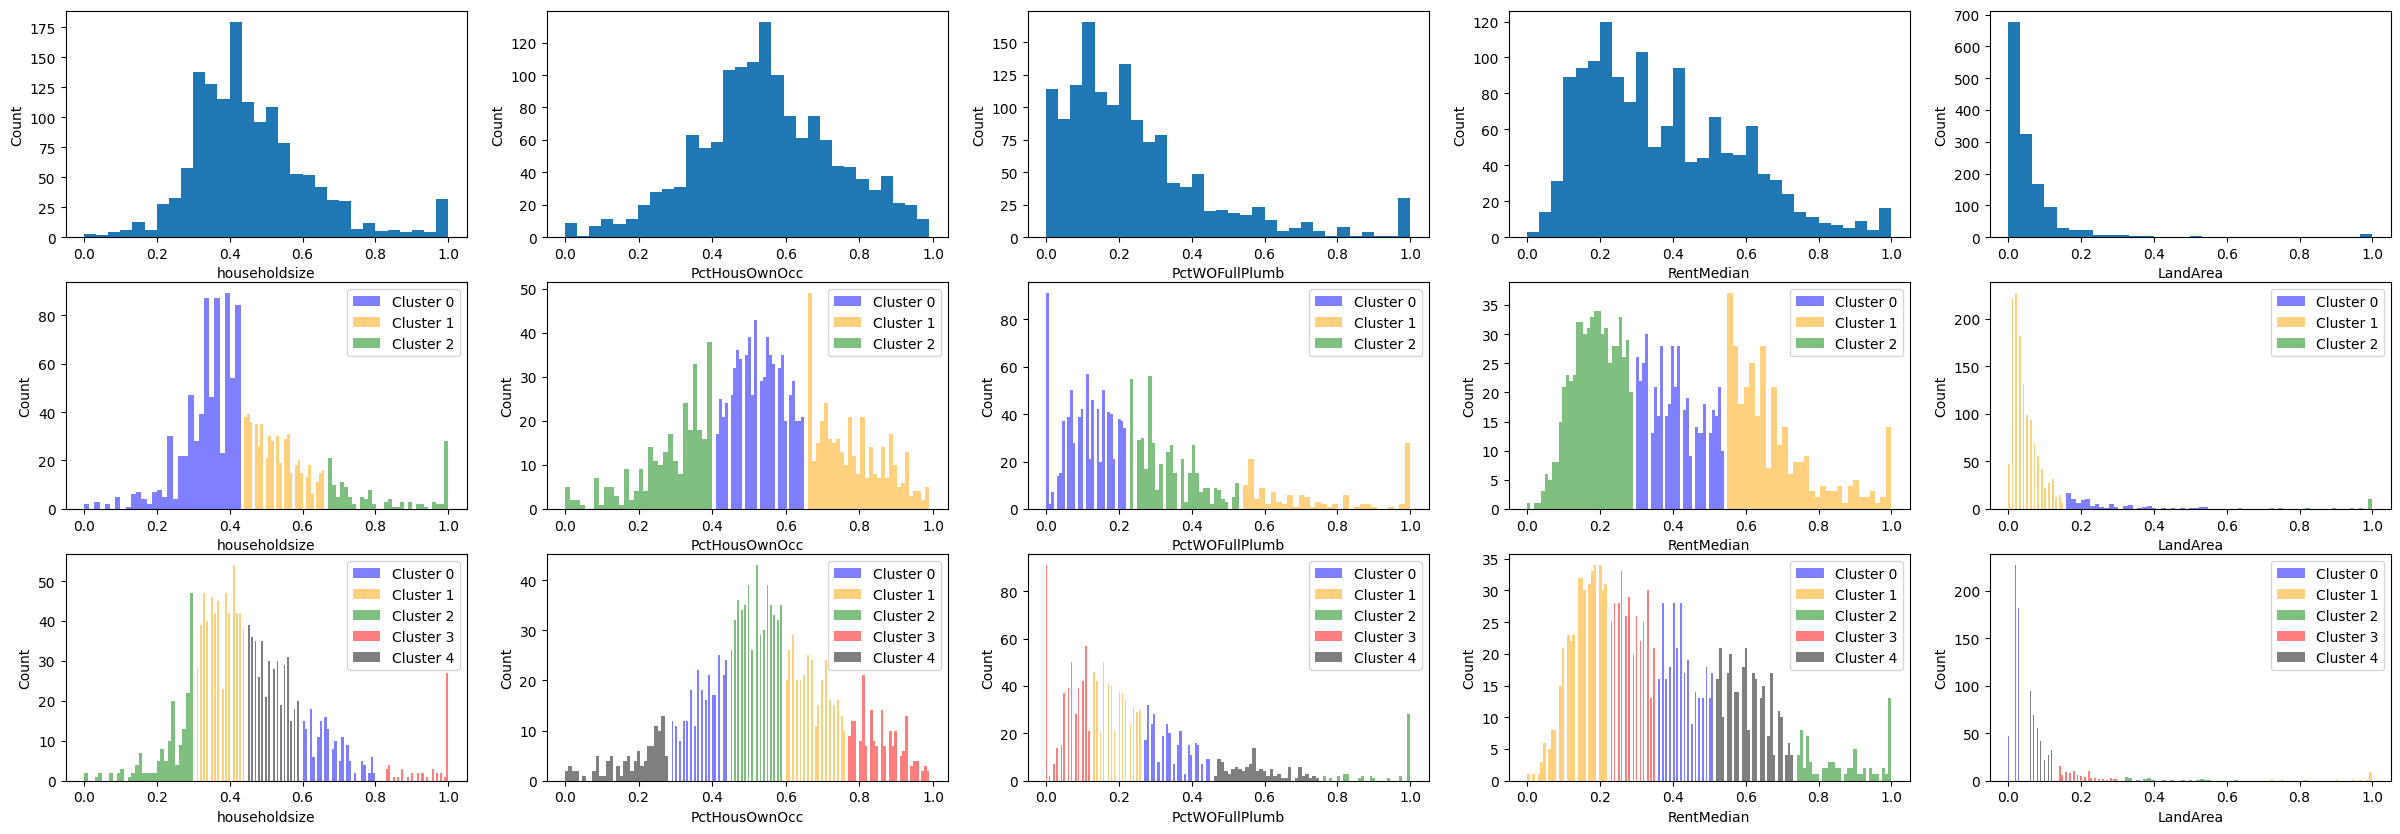

In [ ]:
num_clusters = 5

#Hide the messages
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

def KMeans_clustering(table,feature,num_clusters):
  tempt = table.copy()
  # g = sns.FacetGrid(table)
  # g = g.map(plt.hist,feature,bins=30,alpha = 1)
  kmeans = KMeans(n_clusters = num_clusters).fit(pd.DataFrame(tempt[feature]));
  tempt['label'] = kmeans.labels_
  # g = sns.FacetGrid(tempt,hue = 'label')
  # g = g.map(plt.hist,feature,bins=30,alpha = 1)
  return kmeans,kmeans.labels_


fig,ax = plt.subplots(nrows = 3,ncols = len(list_of_features),figsize = (30,10))

for i in range(len(list_of_features)):
  ax[0,i].hist(X_train[list_of_features[i]],bins = 30)
  ax[0,i].set_xlabel(list_of_features[i])
  ax[0,i].set_ylabel('Count')

for i in range(len(list_of_features)):
    kmeans_labels = KMeans_clustering(X_train, list_of_features[i], 3)[1]

    unique_labels = np.unique(kmeans_labels)
    colors = ['blue', 'orange', 'green']  # Define colors for each cluster label

    # Plot histograms for each feature
    for label, color in zip(unique_labels, colors):
        data_for_label = X_train[list_of_features[i]][kmeans_labels == label]
        ax[1, i].hist(data_for_label, bins=30, alpha=0.5, label=f'Cluster {label}', color=color)

    ax[1, i].set_xlabel(list_of_features[i])
    ax[1, i].set_ylabel('Count')
    ax[1, i].legend()

for i in range(len(list_of_features)):
    kmeans_labels = KMeans_clustering(X_train, list_of_features[i], 5)[1]

    unique_labels = np.unique(kmeans_labels)
    colors = ['blue', 'orange', 'green','red','black']  # Define colors for each cluster label

    # Plot histograms for each feature
    for label, color in zip(unique_labels, colors):
        data_for_label = X_train[list_of_features[i]][kmeans_labels == label]
        ax[2, i].hist(data_for_label, bins=30, alpha=0.5, label=f'Cluster {label}', color=color)

    ax[2, i].set_xlabel(list_of_features[i])
    ax[2, i].set_ylabel('Count')
    ax[2, i].legend()

plt.show()


 householdsize  : 


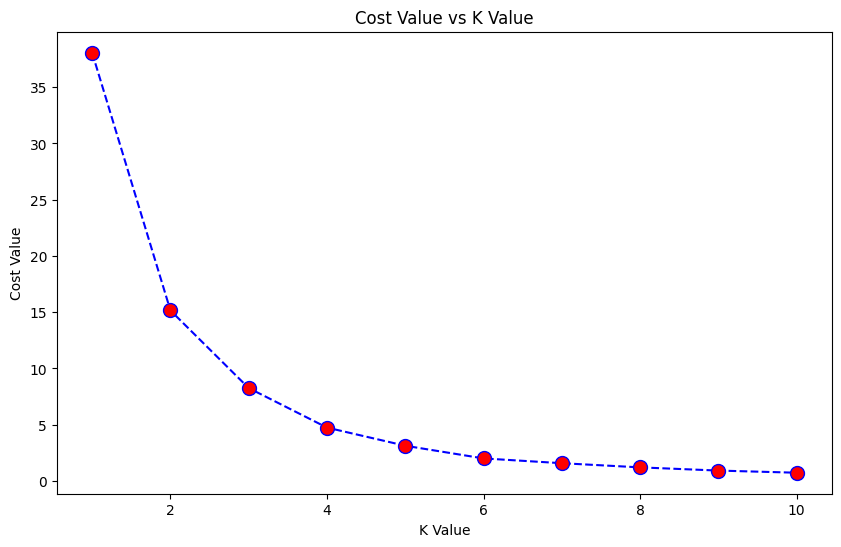


 PctHousOwnOcc  : 


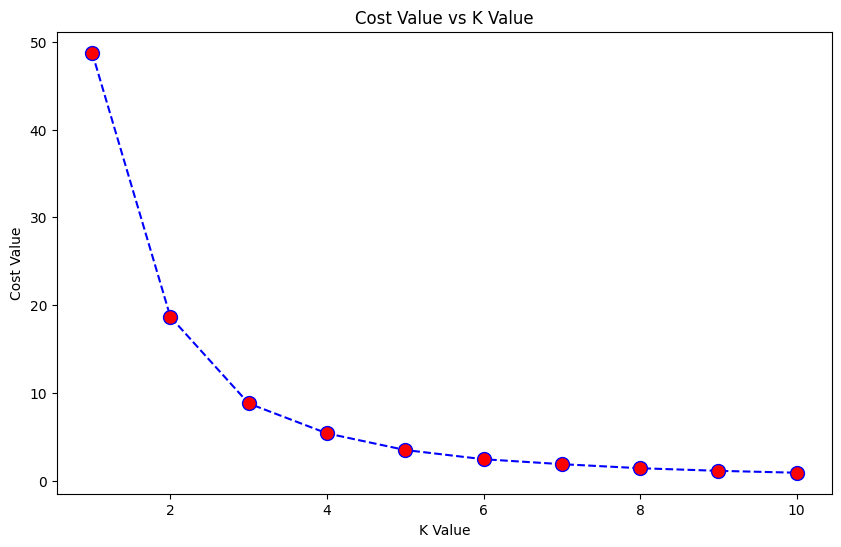


 PctWOFullPlumb  : 


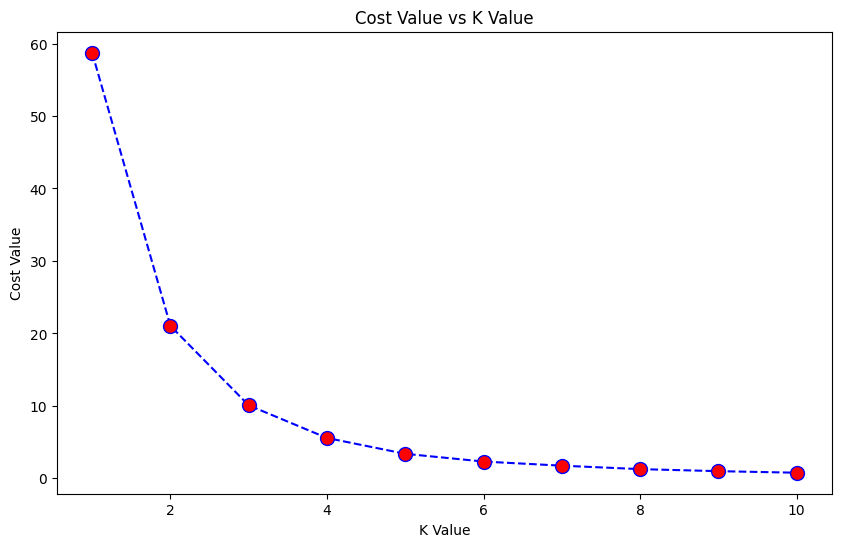


 RentMedian  : 


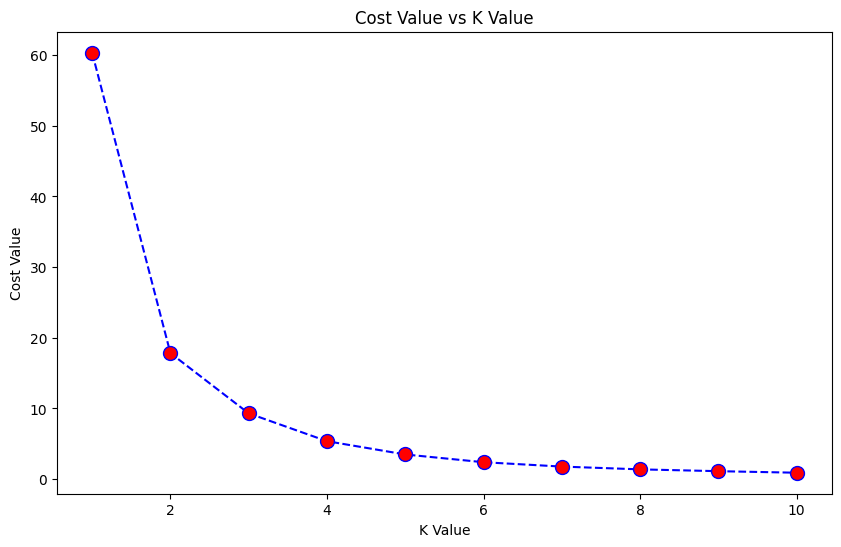


 LandArea  : 


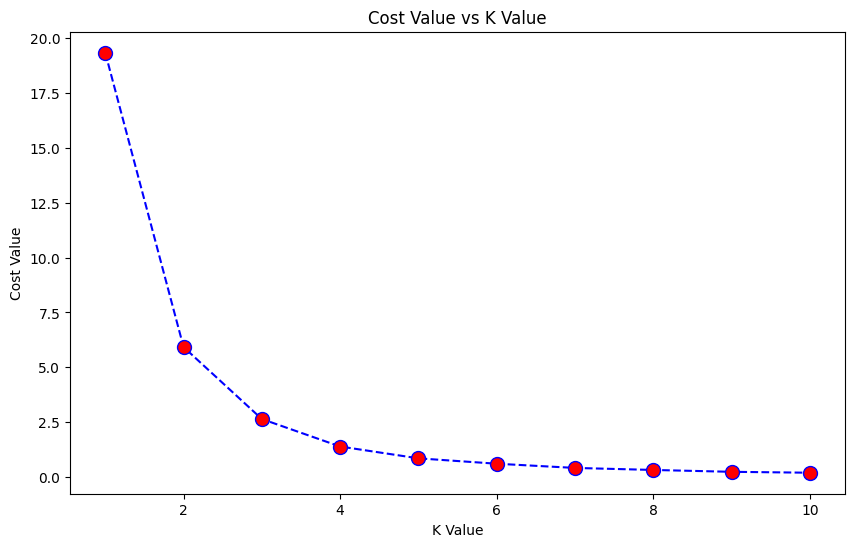

In [ ]:
for feature in list_of_features:
  cost_value = []
  print("\n", feature , " : ")
  for i in range(10):
    kmeans = KMeans_clustering(X_train,feature,i+1)[0]
    cost_value.append(kmeans.inertia_)

  plt.figure(figsize=(10,6))
  plt.plot(range(1,11),cost_value,color = 'blue',linestyle='--',marker='o',
         markerfacecolor='red',markersize=10)
  plt.title('Cost Value vs K Value')
  plt.xlabel('K Value')
  plt.ylabel('Cost Value')
  plt.show()


In [ ]:
class Fuzzify(object):
  def __init__(self,data_series,Min,Max,Mid):
    self.data = data_series
    self.feature = feature
    self.low = Min
    self.high = Max
    self.mid = Mid
    self.universe = np.arange(np.floor(self.low),np.ceil(self.high)+0.2,  0.1)
    self.trimf_low = fuzz.trimf(self.universe,[self.low,self.low,self.mid])
    self.trimf_mid = fuzz.trimf(self.universe,[self.low,self.mid,self.high+0.1])
    self.trimf_high = fuzz.trimf(self.universe,[self.mid,self.high+0.1,self.high+0.1])

  def get_universe(self):
    return self.universe

  #Assign fuzzy membership to each observation in the data series
  #and return a dataframe
  def get_membership(self):
    new_df= pd.DataFrame(self.data)
    new_df['low'] = fuzz.interp_membership(self.universe,self.trimf_low,self.data)
    new_df['mid'] = fuzz.interp_membership(self.universe,self.trimf_mid,self.data)
    new_df['high'] = fuzz.interp_membership(self.universe,self.trimf_high,self.data)
    new_df['membership'] = new_df.loc[:,['low','mid','high']].idxmax(axis = 1)
    new_df['degree'] = new_df.loc[:,['low','mid','high']].max(axis = 1)
    return new_df


In [ ]:
feature_object = []

def get_cluster_MinMaxMid(data,feature_list,num_clusters,fuzzfied = False):

    for feature in feature_list:

        num_clusters = 3
        labels = KMeans_clustering(data,feature,num_clusters)[1]
        feature_tempt = data[feature].loc[:]
        tempt_df = pd.DataFrame({
            'Feature' : feature_tempt,
            'label' : labels
        })

        feature_value = []
        for i in range(num_clusters):
          feature_value.append(tempt_df[tempt_df['label'] == i]['Feature'].min())
          feature_value.append(tempt_df[tempt_df['label'] == i]['Feature'].max())

        feature_value = np.array(feature_value)

        feature_min = feature_value.min()
        feature_max = feature_value.max()
        feature_mid = np.median(feature_value)

        # print(feature_min)
        # print(feature_max)
        # print(feature_mid)

        if fuzzfied == True:
            tempt_object = Fuzzify(feature_tempt,feature_min,feature_max,feature_mid)
            feature_object.append(tempt_object)

        min_max_mid = {
            'df' : feature_tempt,
            'min' : feature_min,
            'max' : feature_max,
            'mid' : feature_mid
        }

    return min_max_mid


In [ ]:
# copy_list_of_features = ['population', 'indianPerCap', 'NumUnderPov', 'PctBSorMore', 'PctOccupManu', 'MalePctDivorce', 'PctKids2Par', 'PctTeen2Par', 'PersPerOccupHous', 'PctHousOwnOcc', 'PctHousNoPhone', 'MedRentPctHousInc', 'MedOwnCostPctInc', 'NumInShelters', 'LandArea']
copy_list_of_features = list_of_features
#copy_list_of_features = ['agePct16t24', 'pctWPubAsst', 'PersPerRentOccHous', 'PctWOFullPlumb', 'NumInShelters']


min_max_mid = get_cluster_MinMaxMid(X_train,[copy_list_of_features[0]],3)

feature1_object = Fuzzify(min_max_mid['df'],min_max_mid['min'],min_max_mid['max'],min_max_mid['mid'])
fuzzified_feature1 = feature1_object.get_membership()

fuzzified_feature1.head()

,householdsize,low,mid,high,membership,degree
557,0.34,0.370370,0.629630,0.0,mid,0.629630
694,0.45,0.166667,0.833333,0.0,mid,0.833333
1718,0.31,0.425926,0.574074,0.0,mid,0.574074
1342,0.37,0.314815,0.685185,0.0,mid,0.685185
1159,0.40,0.259259,0.740741,0.0,mid,0.740741


In [ ]:
#Calculate X membership function
get_cluster_MinMaxMid(X_train,copy_list_of_features,3,fuzzfied = True)

{'df': 557     0.33
 694     0.06
 1718    0.02
 1342    0.04
 1159    0.16
         ... 
 1130    0.01
 1294    0.02
 860     0.01
 1459    0.04
 1126    0.03
 Name: LandArea, Length: 1395, dtype: float64,
 'min': 0.0,
 'max': 1.0,
 'mid': 0.35500000000000004}

In [ ]:
#Calculate Y membership function
get_cluster_MinMaxMid(y_train,['ViolentCrimesPerPop'],3,fuzzfied = True)

{'df': 557     0.36
 694     0.38
 1718    0.21
 1342    0.02
 1159    1.00
         ... 
 1130    0.09
 1294    0.15
 860     0.13
 1459    0.37
 1126    0.17
 Name: ViolentCrimesPerPop, Length: 1395, dtype: float64,
 'min': 0.0,
 'max': 1.0,
 'mid': 0.40499999999999997}

In [ ]:
X_train[copy_list_of_features]

,householdsize,PctHousOwnOcc,PctWOFullPlumb,RentMedian,LandArea
557,0.34,0.50,0.16,0.22,0.33
694,0.45,0.53,0.12,0.22,0.06
1718,0.31,0.49,0.47,0.09,0.02
1342,0.37,0.55,0.36,0.22,0.04
1159,0.40,0.27,0.49,0.44,0.16
...,...,...,...,...,...
1130,0.38,0.31,0.15,0.53,0.01
1294,0.24,0.76,0.17,0.51,0.02
860,0.29,0.56,0.07,0.40,0.01
1459,0.28,0.49,0.14,0.59,0.04


In [ ]:
train_data = X_train[copy_list_of_features]
train_data = train_data.join(y_train)

In [ ]:
# train_data = X_train[copy_list_of_features]
# train_data = train_data + y_train

###Attention

def get_rule(train_data,feature_object):
  rule_df = train_data.copy()
  rule_df['degree'] = np.ones(X_train.shape[0])
  for col in train_data.columns[:]:
    idx = train_data.columns.get_loc(col)
    feature_membership = feature_object[idx].get_membership()
    rule_df[col] = feature_membership['membership']
    rule_df['degree'] *= feature_membership['degree']
  final_rule = rule_df
  final_rule['ViolentCrimesPerPop Value'] = y_train.iloc[:]
  final_rule = final_rule.groupby(list(rule_df.columns[:-3])).max()
  final_rule = final_rule.reset_index()
  col_to_move = final_rule.pop('degree')
  final_rule['degree'] = col_to_move
  return final_rule

In [ ]:
rules = get_rule(train_data,feature_object)
rules.sort_values(by = 'degree',ascending=False,inplace = True)
rules

,householdsize,PctHousOwnOcc,PctWOFullPlumb,RentMedian,LandArea,ViolentCrimesPerPop,ViolentCrimesPerPop Value,degree
55,mid,mid,low,mid,low,mid,1.00,0.517133
10,high,mid,low,mid,low,mid,0.56,0.481256
31,mid,high,low,high,low,low,0.83,0.472172
59,mid,mid,mid,low,low,mid,1.00,0.468988
62,mid,mid,mid,mid,low,mid,1.00,0.464195
...,...,...,...,...,...,...,...,...
42,mid,low,mid,high,low,low,0.19,0.070092
41,mid,low,low,mid,mid,high,0.95,0.065617
30,mid,high,high,low,low,low,0.19,0.063081
16,low,low,low,high,low,low,0.18,0.062400


# **Build Model**

In [ ]:
#Define input and output
antecedent = {}
for feature in copy_list_of_features:
   antecedent[feature] = ctrl.Antecedent(np.arange(0,1+0.1,0.1),feature)

column_name = y_train.columns[0]

consequent = ctrl.Consequent(np.arange(0,1+0.1,0.1), column_name)

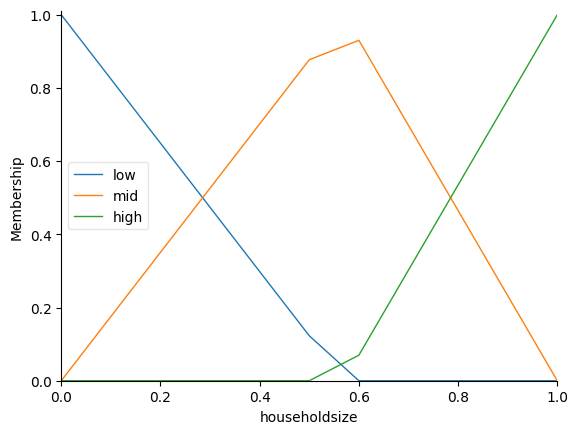

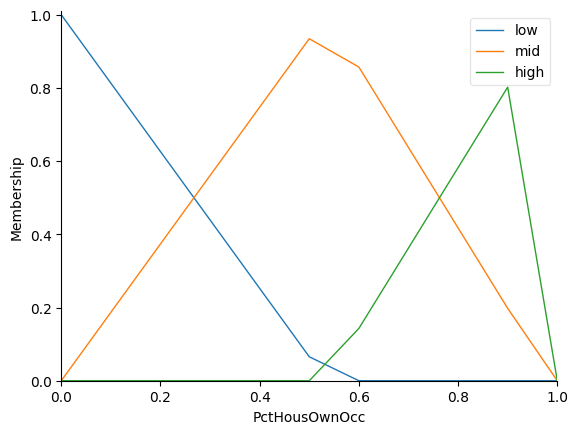

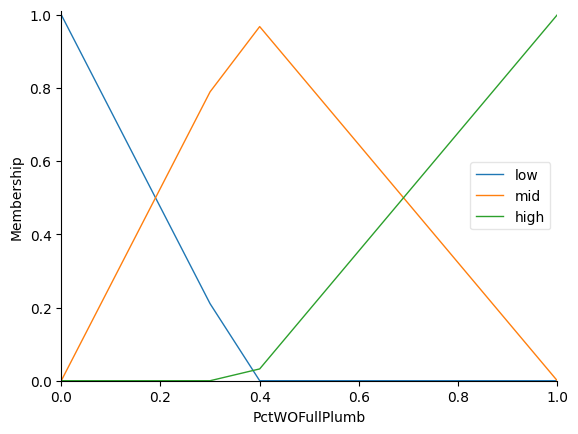

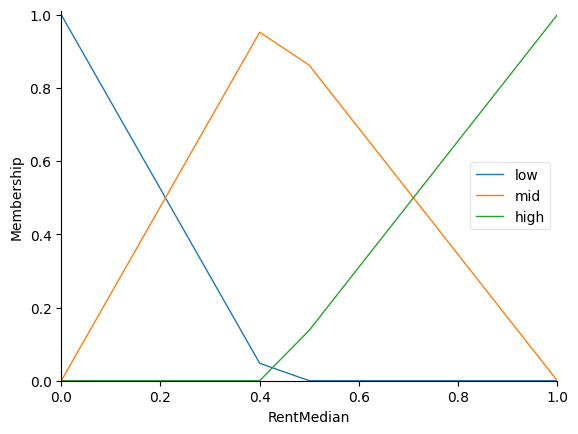

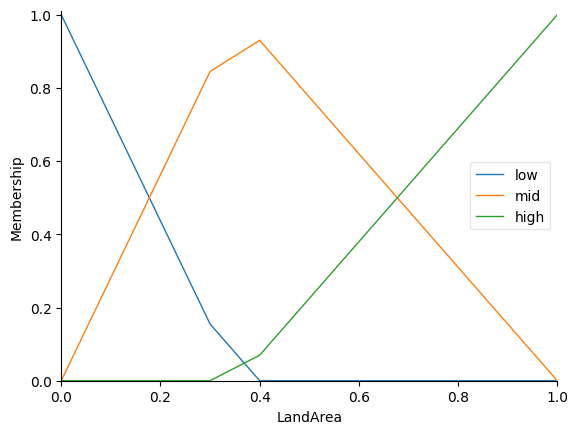

In [ ]:
#Define membership function
for feature in antecedent.keys():

  min_max_mid = get_cluster_MinMaxMid(X_train,[feature],3)

  low = min_max_mid['min']
  high = min_max_mid['max']
  mid = min_max_mid['mid']

  antecedent[feature]['low'] = fuzz.trimf(antecedent[feature].universe,[low,low,mid])
  antecedent[feature]['mid'] = fuzz.trimf(antecedent[feature].universe,[low,mid,high])
  antecedent[feature]['high'] = fuzz.trimf(antecedent[feature].universe,[mid,high,high])
  antecedent[feature].view()

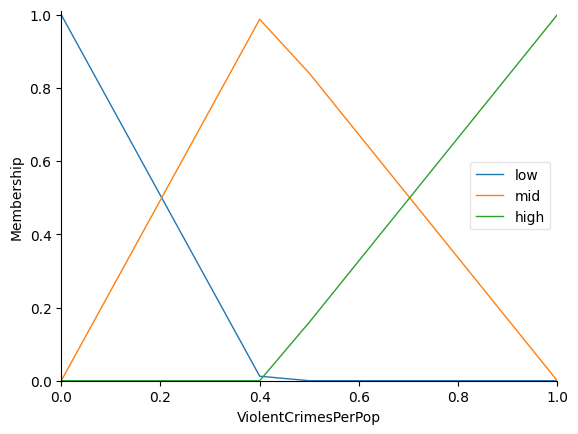

In [ ]:
# low = y_train.iloc[:,0].min()
# high = y_train.iloc[:,0].max()
# mid = np.median(np.arange(low,high+0.1,0.1))

min_max_mid = get_cluster_MinMaxMid(y_train,[y_train.columns[0]],3)

low = min_max_mid['min']
high = min_max_mid['max']
mid = min_max_mid['mid']

consequent['low'] = fuzz.trimf(consequent.universe,[low,low,mid])
consequent['mid'] = fuzz.trimf(consequent.universe,[low,mid,high])
consequent['high'] = fuzz.trimf(consequent.universe,[mid,high,high])
consequent.view()

In [ ]:
rules_list = []
num_row = len(rules)
tempt_rules = rules[:num_row][rules.columns[:-2]]

for i in range(num_row):
  row = tempt_rules.iloc[i]
  num_item = row.shape[0]

  rule = None
  for j in range(num_item-1):
    if rule is None:
        rule = antecedent.get(row.index[j])[row[0]]
    else:
        rule &= antecedent.get(row.index[j])[row[0]]

  rules_list.append(ctrl.Rule(rule,consequent[row[-1]]))

In [ ]:
rules_list

[IF (((householdsize[mid] AND PctHousOwnOcc[mid]) AND PctWOFullPlumb[mid]) AND RentMedian[mid]) AND LandArea[mid] THEN ViolentCrimesPerPop[mid]
 	AND aggregation function : fmin
 	OR aggregation function  : fmax,
 IF (((householdsize[mid] AND PctHousOwnOcc[mid]) AND PctWOFullPlumb[mid]) AND RentMedian[mid]) AND LandArea[mid] THEN ViolentCrimesPerPop[mid]
 	AND aggregation function : fmin
 	OR aggregation function  : fmax,
 IF (((householdsize[mid] AND PctHousOwnOcc[mid]) AND PctWOFullPlumb[mid]) AND RentMedian[mid]) AND LandArea[mid] THEN ViolentCrimesPerPop[mid]
 	AND aggregation function : fmin
 	OR aggregation function  : fmax,
 IF (((householdsize[high] AND PctHousOwnOcc[high]) AND PctWOFullPlumb[high]) AND RentMedian[high]) AND LandArea[high] THEN ViolentCrimesPerPop[mid]
 	AND aggregation function : fmin
 	OR aggregation function  : fmax,
 IF (((householdsize[mid] AND PctHousOwnOcc[mid]) AND PctWOFullPlumb[mid]) AND RentMedian[mid]) AND LandArea[mid] THEN ViolentCrimesPerPop[mid]

In [ ]:
consequent_ctrl = ctrl.ControlSystem(rules_list)
pred = ctrl.ControlSystemSimulation(consequent_ctrl)

Prediction :  0.5000000000000001


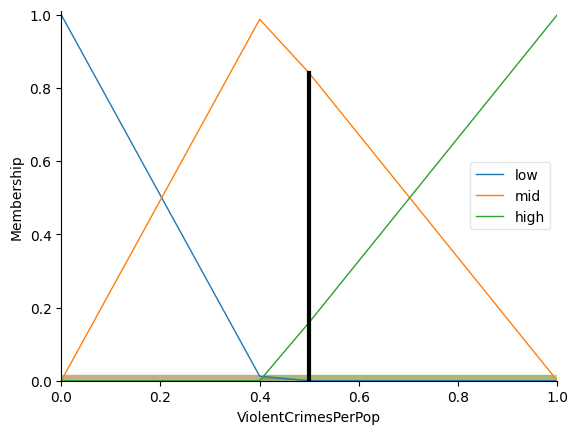

In [ ]:
#Input value
# inputs_dict = {
#     'medIncome': 0.69,
#     'PctPopUnderPov': 0.03,
#     'PctEmplManu': 0.39,
#     'NumInShelters': 0.00000001,
# }

input_values = [0.9,0.03,0.99,0.01,0.01]
input_dict = {}

if len(input_values) != len(copy_list_of_features):
  print("Length of input_value is not equal to length of list of features")

else:
  for feature,input in zip(copy_list_of_features,input_values):
     input_dict[feature] = input

  pred.inputs(input_dict)

  #Compute and view the result
  pred.compute()
  print("Prediction : ",pred.output['ViolentCrimesPerPop'])
  consequent.view(sim = pred)

In [ ]:
#Test and refine model